In [1]:
!pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 


In [2]:
!wget https://github.com/ZilongBai/KDD2020BMGUFS/raw/master/dataset.zip
!unzip dataset.zip
!mkdir results

--2022-07-06 15:34:28--  https://github.com/ZilongBai/KDD2020BMGUFS/raw/master/dataset.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZilongBai/KDD2020BMGUFS/master/dataset.zip [following]
--2022-07-06 15:34:29--  https://raw.githubusercontent.com/ZilongBai/KDD2020BMGUFS/master/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1643935 (1.6M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   1.57M  --.-KB/s    in 0.009s  

2022-07-06 15:34:29 (181 MB/s) - ‘dataset.zip’ saved [1643935/1643935]

Archive:  dataset.zip
  inflating: dataset/Blo

In [3]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    # from sklearn.utils.linear_assignment_ import linear_assignment
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
    #return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    return sum(w[ind]) * 1.0 / y_pred.size

In [4]:
# This is file of methods for paper "Block Model Guided Unsupervised Feature Selection" accepted at SIGKDD 2020
# Authors: Zilong Bai, Hoa Nguyen, Ian Davidson
# Code implemented by: Zilong Bai @ UC Davis
# This script demonstrates how to use Algorithm 1 BMGUFS from our paper on the BlogCatalog data for feature selection.

import numpy as np
import torch

datastr = 'dataset/'
resultstr = 'results/'

print('Loading raw graph...')
Original_X = np.genfromtxt((datastr+'BlogCatalog_Network.csv'),delimiter=',')

print('Loading nodal attributes...')
Original_Y = np.genfromtxt((datastr+'BlogCatalog_Attributes.csv'),delimiter=',')

kmin = 6; kmax = 6;
repmax = 10;
gammas = [4] # Grid-search
betas = [0]
MAXITER = 200 # 200 iterations. 
step_size = 1e-2
delta = 1e-6

repselected = 3 # Lowest RRE.

kstr = str(kmin);

# At each k, we first find which block model achieves the lowest reconstruction loss
rep = repselected
repstr = str(rep) # Already aligned rep to start at 1. No need to add 1 to translate to matlab indexing.

print('Loading block allocation ...')
Original_F = np.genfromtxt((datastr+'blogcatalog_nmtf_'+kstr+'_'+repstr+'_F.csv'),delimiter=',');

print('Loading mixing/image matrix ...')
Original_Ms = np.genfromtxt((datastr+'blogcatalog_nmtf_'+kstr+'_'+repstr+'_M.csv'),delimiter=',');


Loading raw graph...
Loading nodal attributes...
Loading block allocation ...
Loading mixing/image matrix ...


In [5]:
# This is file of methods for paper "Block Model Guided Unsupervised Feature Selection" accepted at SIGKDD 2020
# Authors: Zilong Bai, Hoa Nguyen, Ian Davidson
# Code implemented by: Zilong Bai @ UC Davis
# This module implements Algorithm 1 for BMGUFS from our paper.

import numpy as np
from numpy import linalg as LA
import torch
import pygad


def solver_delta_enhanced_sparse(X,Y,F,Ms,delta):
# Y is n x f feature matrix. Nonnegative.
# F is n x k block allocation matrix. Binary.
# Ms is k x k image/mixing matrix of the raw network topology.
# beta is the ratio of KL-divergence term.
# delta is minor postive scalar to avoid trivial solution.
# MAXITER is a large integer for the maximum amount of iterations.
# step_size is the step size for gradient descent
    [n,f] = Y.shape
    k = F.shape[1]
    D = np.identity(k)
    for j in range(k):
        D[j,j] = LA.norm(F[:,j])**2

    cuda = torch.device('cuda')

    F = torch.from_numpy(F).float().to(cuda)
    Y = torch.from_numpy(Y).float().to(cuda)
    D = torch.from_numpy(D).float().to(cuda)
    X = torch.from_numpy(X).float().to(cuda)
        
    Dbar = torch.mm(D.inverse(),torch.mm(F.t(),Y))

    Ms = Ms + np.ones((k,k))*delta
    Ms = torch.from_numpy(Ms).float().to(cuda)
    
    def fitness_fun(r, solution_idx):
        r = torch.from_numpy(r).float().to(cuda)
        for l in range(f):
          r[l] = max(r[l],0)
        normr = torch.norm(r)
        r = r/normr
        R = torch.diag(r)
        M = torch.mm(torch.mm(Dbar,R),Dbar.t())
        M = M + torch.ones(k,k).to(cuda)*delta
        A = torch.mm(torch.mm(Y,R),Y.t())
        KK = torch.mm(torch.mm(F,M),F.t())        
        loss = np.linalg.norm(KK.cpu().numpy() - A.cpu().numpy(), ord = 'fro')
        fitness = 1/loss
        return fitness

    ga_instance = pygad.GA(num_generations=500,
                           num_parents_mating=10,
                           fitness_func=fitness_fun,
                           sol_per_pop=20,
                           num_genes=8189,
                           init_range_low=0.0,
                           init_range_high=1.0,
                           mutation_percent_genes=0.01,
                           mutation_type="random")
    
    ga_instance.run()
    
    return ga_instance


In [6]:
X = np.copy(Original_X)
Y = np.copy(Original_Y)
Ms = np.copy(Original_Ms);
F = np.copy(Original_F);
E = X + X.transpose()
E[np.where(X>0)] = 1
ga_instance = solver_delta_enhanced_sparse(X,Y,F,Ms,delta)

r, solution_fitness, solution_idx = ga_instance.best_solution()
np.savetxt(resultstr+'ours_blogcatalog_r.csv',r,delimiter=',')

RuntimeError: ignored

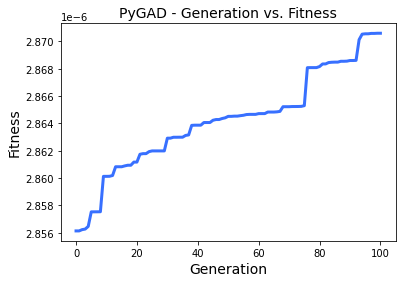

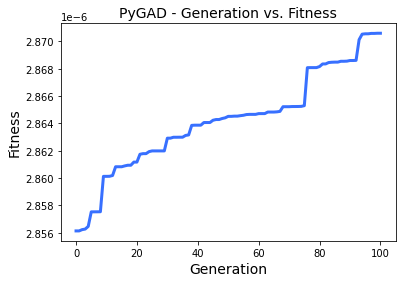

In [ ]:
ga_instance.plot_fitness()

In [5]:

# Section 5.3 .... accuracy for d = [16 364 128 200 600] for block model with lowest RRE
import csv
import numpy as np
import sklearn.preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score , adjusted_mutual_info_score
file2 = open("/content/dataset/BlogCatalog_Attributes.csv")
data2 = csv.reader(file2)
st = []
for m in data2:
    st.append(m)
file2.close()
lbl = np.genfromtxt(('/content/labels.csv'),delimiter=',')
lbl = lbl.astype(np.int32)
st = np.array(st)
st = st.astype(np.int64)
AccV = []
MILwVec = []
d = np.array([16,64,128,200,600])
file = open('/content/ours_blogcatalog_r.csv')
data = csv.reader(file)
r = []
for rL in data:
    r.append(rL)
file.close()
r2 = [float(r[i][0]) for i in range(0,len(r))]
r2 = np.array(r2)
r_Srt = np.sort(r2)[::-1]

for j in d:  
  cnt = 0;
  indx = [];
  while True:
    index1 = np.where(r2 == r_Srt[cnt])
    for i in range(0,len(index1)):
        indx.append(index1[i][0])
    if cnt == j:
      break
    cnt = cnt + 1;
  indx = np.array(indx)
  indx = indx.astype(np.int64)
  indx = indx[:j]
  st2 = st[:,indx]
  st2 = st2.astype(np.float64)
  sklearn.preprocessing.normalize(st2, norm='l2', axis=1, copy=False, return_norm=False)
  kmeans = sklearn.cluster.KMeans(n_clusters=6, init='k-means++', n_init=20, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='elkan').fit(st2)
  Lb = kmeans.labels_
  AC = acc(lbl,Lb)
  # MILw = mutual_info_score(lbl, Lb, contingency=None)
  MILw = adjusted_mutual_info_score(lbl, Lb, average_method='arithmetic')
  MILwVec.append(MILw)
  AccV.append(AC)
AccV = np.array(AccV)
MILwVec = np.array(MILwVec)
AccV = 100*AccV

<Figure size 720x360 with 0 Axes>

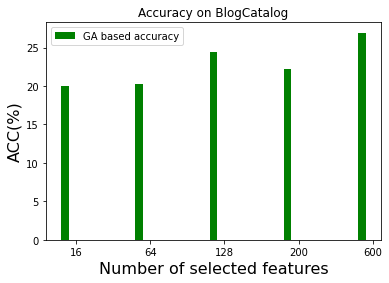

In [8]:
# plot bars for accuracy
#

# MImax = 100*Accmax
fig = plt.figure(figsize = (10, 5))
plt.show()
x = np.arange(5)
width = 0.1
# plot data in grouped manner of bar type
plt.bar(x-0.15, AccV, width, color='green')
# plt.bar(x, Accmax, width, color='yellow')
# plt.bar(x-0.3, AC, width, color='red')
plt.xticks(x,['16','64','128','200','600'])
plt.xlabel("Number of selected features",fontsize=16)
plt.ylabel("ACC(%)",fontsize=16)
plt.title("Accuracy on BlogCatalog")
plt.legend(["GA based accuracy"],loc='upper left')
plt.show()